# Preprocessing

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch

In [4]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.vfm.model.reg.gradient_boost import GradientBoost
from src.vfm.model.nn.swt_tft import SWTTFTModel
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel, PhysicsModel
from src.utils import *
import matplotlib.pyplot as plt
import os

c:\Users\perer\Documents\Code\pcperera\vfm\.venv\Lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
connection = Connection()
# Get client
client = connection.get_client()

In [6]:
df_all_wells = connection.get_data(client, wells=get_all_wells())

In [7]:
df_all_wells.columns


Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [8]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [9]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W08... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W10... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W11... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W15... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W18... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_

270

In [10]:
summarize_null(df_all_wells_preprocessed)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [11]:
df_with_targets = df_all_wells_preprocessed.dropna(subset=dependent_vars)
df_with_targets.shape

(270, 12)

In [12]:
summarize_null(df_with_targets)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [25]:
df_train, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_with_targets, test_size=0.3)
len(df_train), len(df_test)

(188, 82)

In [26]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train)

In [27]:
model.physics_score(df_test)

ValueError: Input contains NaN.

In [ ]:
model.hybrid_score(df_test)

{'qo': {'r2': 0.6839256248700679,
  'mae': 25.07474600296159,
  'rmse': 30.113884795822464},
 'qw': {'r2': -0.046294604581280874,
  'mae': 28.598431651672804,
  'rmse': 110.27620393591704},
 'qg': {'r2': 0.886493627888699,
  'mae': 1388.6552248240578,
  'rmse': 2258.5457595454727},
 'wgr': {'r2': 0.029249838823143692,
  'mae': 0.0032907075554686467,
  'rmse': 0.010478583971556214}}

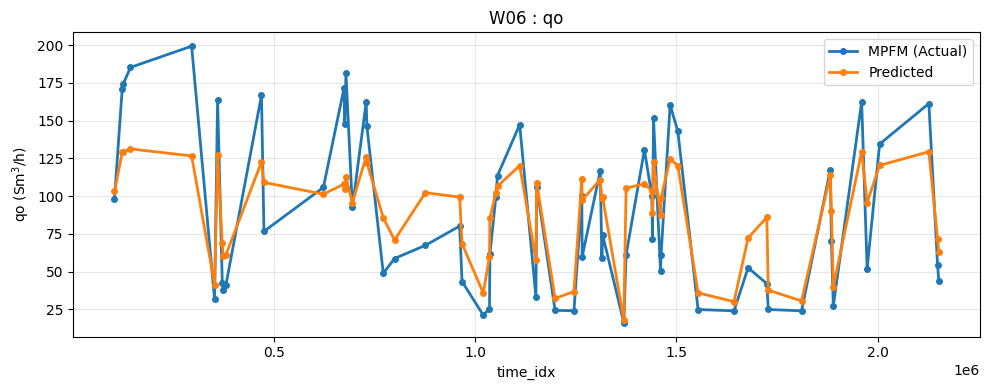

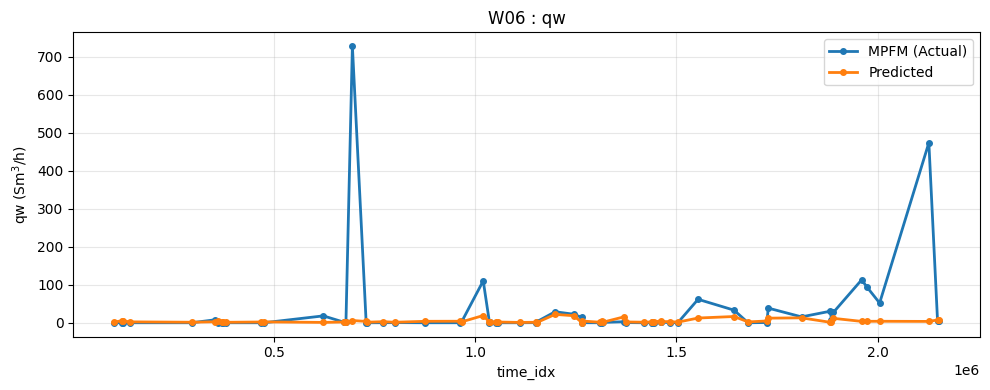

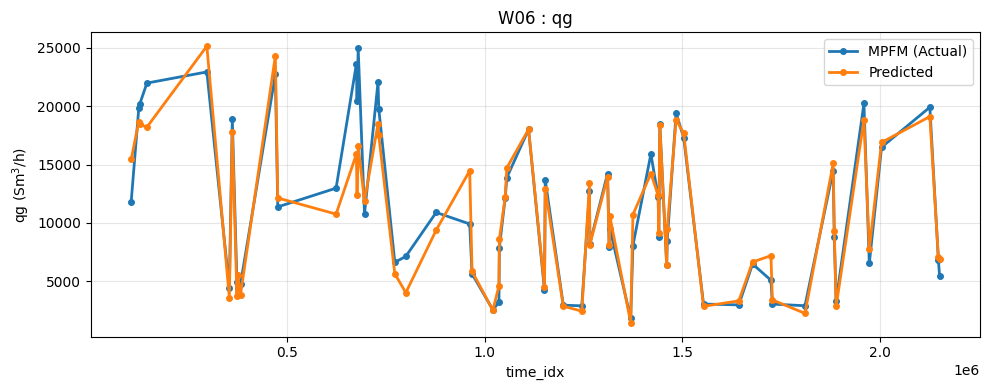

In [ ]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [ ]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [ ]:
# lowo_with_partial_calibration(df=df_with_targets)